# Gridworld MDP, Value Iteration, Simulation & Visualizations

This notebook implements a Gridworld Markov Decision Process (MDP), solves it with Value Iteration, extracts a greedy policy, runs simulations, and produces several visualizations (value heatmaps, policy diagrams, convergence plots, trajectories, visit heatmaps, and reward plots).

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, Dict, List
import random
import math
import os

# helper display function (the notebook environment may provide caas_jupyter_tools.display_dataframe_to_user)
try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    display_dataframe_to_user = None

plt.rcParams["figure.figsize"] = (6, 5)


In [2]:

@dataclass
class GridMDP:
    rows: int
    cols: int
    terminals: Dict[Tuple[int,int], float]
    obstacles: List[Tuple[int,int]]
    step_reward: float = -0.04
    slip_prob: float = 0.1
    actions: List[Tuple[int,int]] = None

    def __post_init__(self):
        self.actions = [(-1,0),(0,1),(1,0),(0,-1)]
        self.states = [(r,c) for r in range(self.rows) for c in range(self.cols) if (r,c) not in self.obstacles]

    def in_bounds(self, s):
        r,c = s
        return 0 <= r < self.rows and 0 <= c < self.cols and s not in self.obstacles

    def next_state_probabilities(self, s, a_idx):
        if s in self.terminals:
            return [(1.0, s, self.terminals[s], True)]
        intended = self.actions[a_idx]
        perp = {0:[(0,1),(0,-1)], 1:[(-1,0),(1,0)], 2:[(0,1),(0,-1)], 3:[(-1,0),(1,0)]}
        results = {}
        probs = [(1 - 2*self.slip_prob, intended)] + [(self.slip_prob, p) for p in perp[a_idx]]
        for p, act in probs:
            nr = s[0] + act[0]
            nc = s[1] + act[1]
            ns = (nr,nc)
            if not self.in_bounds(ns):
                ns = s
            reward = self.terminals.get(ns, self.step_reward)
            done = ns in self.terminals
            results[ns] = results.get(ns, 0.0) + p
        return [(results[ns], ns, (self.terminals[ns] if ns in self.terminals else self.step_reward), (ns in self.terminals)) for ns in results]


In [3]:

def value_iteration(mdp: GridMDP, gamma=0.99, theta=1e-4, max_iters=1000):
    V = {s: 0.0 for s in mdp.states}
    iteration = 0
    deltas = []
    while True:
        delta = 0.0
        iteration += 1
        newV = V.copy()
        for s in mdp.states:
            if s in mdp.terminals:
                newV[s] = mdp.terminals[s]
                continue
            action_vals = []
            for a_idx in range(len(mdp.actions)):
                q = 0.0
                for prob, ns, reward, done in mdp.next_state_probabilities(s, a_idx):
                    q += prob * (reward + gamma * V[ns])
                action_vals.append(q)
            best = max(action_vals)
            newV[s] = best
            delta = max(delta, abs(V[s] - newV[s]))
        V = newV
        deltas.append(delta)
        if delta < theta or iteration >= max_iters:
            break
    policy = {}
    for s in mdp.states:
        if s in mdp.terminals:
            policy[s] = None
            continue
        best_a = None
        best_q = -1e9
        for a_idx in range(len(mdp.actions)):
            q = 0.0
            for prob, ns, reward, done in mdp.next_state_probabilities(s, a_idx):
                q += prob * (reward + gamma * V[ns])
            if q > best_q:
                best_q = q
                best_a = a_idx
        policy[s] = best_a
    return V, policy, deltas, iteration

def simulate_policy(mdp: GridMDP, policy: Dict[Tuple[int,int], int], episodes=100, max_steps=100, epsilon=0.0):
    trajectories = []
    rewards = []
    visit_counts = {s:0 for s in mdp.states}
    for ep in range(episodes):
        start = random.choice([s for s in mdp.states if s not in mdp.terminals])
        s = start
        traj = [s]
        total_r = 0.0
        for t in range(max_steps):
            if s in mdp.terminals:
                break
            visit_counts[s] += 1
            if random.random() < epsilon:
                a = random.randrange(len(mdp.actions))
            else:
                a = policy[s]
            outcomes = mdp.next_state_probabilities(s, a)
            probs = [x[0] for x in outcomes]
            idx = np.random.choice(len(outcomes), p=probs)
            prob, ns, r, done = outcomes[idx]
            total_r += r
            s = ns
            traj.append(s)
            if done:
                break
        trajectories.append(traj)
        rewards.append(total_r)
    return trajectories, rewards, visit_counts

# Plot helpers (matplotlib only)
def plot_value_heatmap(V, mdp: GridMDP, title="Value function"):
    grid = np.full((mdp.rows, mdp.cols), np.nan)
    for r in range(mdp.rows):
        for c in range(mdp.cols):
            if (r,c) in mdp.obstacles:
                grid[r,c] = np.nan
            elif (r,c) in V:
                grid[r,c] = V[(r,c)]
    fig, ax = plt.subplots()
    im = ax.imshow(grid, origin='upper', interpolation='nearest')
    ax.set_title(title)
    for (r,c), val in np.ndenumerate(grid):
        if np.isnan(val):
            if (r,c) in mdp.obstacles:
                ax.text(c, r, "X", ha="center", va="center", fontsize=12, fontweight='bold')
        else:
            ax.text(c, r, f"{val:.2f}", ha="center", va="center", fontsize=8)
    fig.colorbar(im, ax=ax)
    plt.gca().invert_yaxis()
    plt.show()

def plot_policy(policy, mdp: GridMDP, title="Policy"):
    arrow_map = {0: '↑', 1: '→', 2: '↓', 3: '←', None: '·'}
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, mdp.cols-0.5)
    ax.set_ylim(-0.5, mdp.rows-0.5)
    ax.invert_yaxis()
    ax.set_xticks(range(mdp.cols))
    ax.set_yticks(range(mdp.rows))
    ax.set_title(title)
    for r in range(mdp.rows):
        for c in range(mdp.cols):
            if (r,c) in mdp.obstacles:
                ax.text(c, r, "X", ha="center", va="center", fontsize=14, fontweight='bold')
            elif (r,c) in mdp.terminals:
                ax.text(c, r, f"T\n{mdp.terminals[(r,c)]:.2f}", ha="center", va="center", fontsize=10)
            elif (r,c) in policy:
                ax.text(c, r, arrow_map[policy[(r,c)]], ha="center", va="center", fontsize=14)
            else:
                ax.text(c, r, " ", ha="center", va="center", fontsize=10)
    plt.grid(True)
    plt.show()

def plot_convergence(deltas, title="Value Iteration Convergence"):
    fig, ax = plt.subplots()
    ax.plot(deltas)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Max delta")
    ax.set_yscale('log')
    ax.set_title(title)
    plt.show()

def plot_trajectories(trajectories, mdp: GridMDP, n_show=8, title="Sample Trajectories"):
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, mdp.cols-0.5)
    ax.set_ylim(-0.5, mdp.rows-0.5)
    ax.invert_yaxis()
    for i, traj in enumerate(trajectories[:n_show]):
        xs = [p[1] for p in traj]
        ys = [p[0] for p in traj]
        ax.plot(xs, ys, marker='o', label=f"ep{i}", linewidth=1)
    for (r,c) in mdp.obstacles:
        ax.text(c, r, "X", ha="center", va="center", fontsize=12)
    for (r,c), val in mdp.terminals.items():
        ax.text(c, r, f"T\n{val:.2f}", ha="center", va="center", fontsize=10)
    ax.set_title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(1.35,1.0))
    plt.grid(True)
    plt.show()

def plot_visit_heatmap(visit_counts, mdp: GridMDP, title="State Visit Counts"):
    grid = np.zeros((mdp.rows, mdp.cols))
    for r in range(mdp.rows):
        for c in range(mdp.cols):
            if (r,c) in mdp.obstacles:
                grid[r,c] = np.nan
            else:
                grid[r,c] = visit_counts.get((r,c), 0)
    fig, ax = plt.subplots()
    im = ax.imshow(grid, origin='upper', interpolation='nearest')
    ax.set_title(title)
    for (r,c), val in np.ndenumerate(grid):
        if np.isnan(val):
            ax.text(c, r, "X", ha="center", va="center", fontsize=12, fontweight='bold')
        else:
            ax.text(c, r, f"{int(val)}", ha="center", va="center", fontsize=8)
    fig.colorbar(im, ax=ax)
    plt.gca().invert_yaxis()
    plt.show()

def plot_rewards_stats(rewards, title="Episode rewards"):
    fig, ax = plt.subplots()
    ax.plot(rewards, marker='o', linestyle='-', linewidth=0.8, markersize=3, label='episode reward')
    window = max(1, len(rewards)//10)
    running = [np.mean(rewards[max(0,i-window+1):i+1]) for i in range(len(rewards))]
    ax.plot(running, linestyle='--', label=f'run avg (window={window})')
    ax.set_title(title)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total reward")
    plt.legend()
    plt.show()


Value iteration finished: gamma=0.99 in 43 iters, gamma=0.9 in 30 iters.


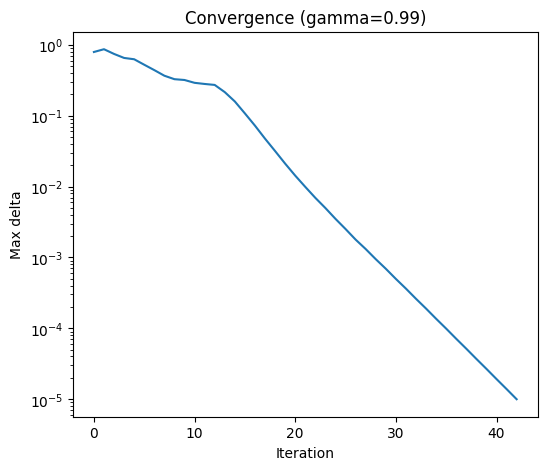

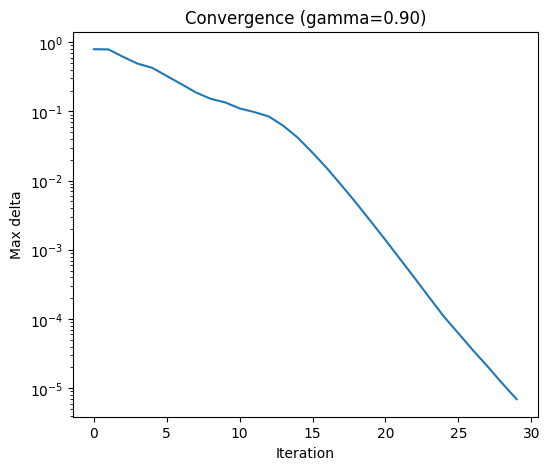

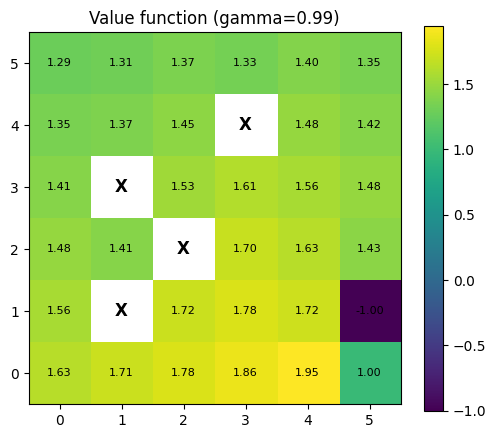

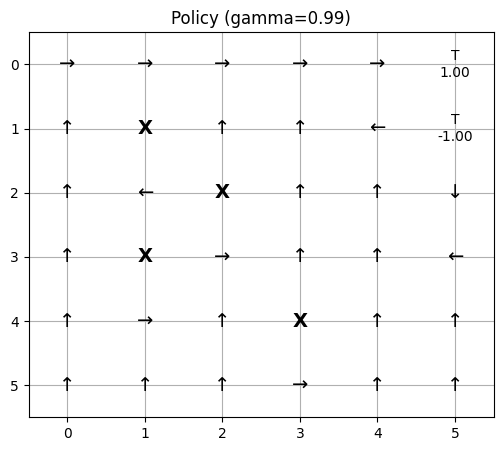

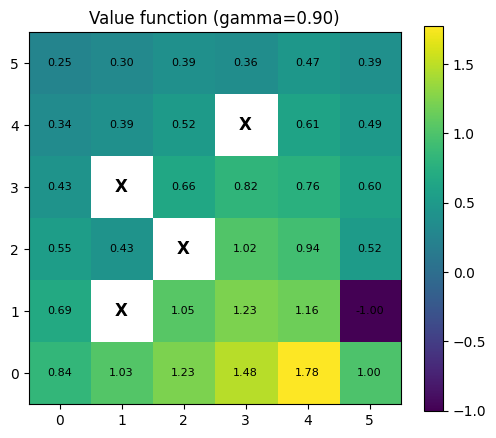

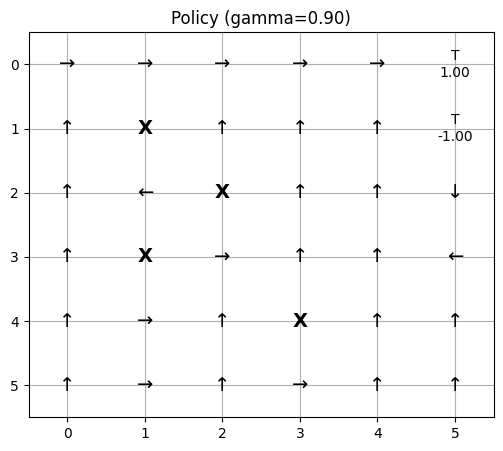

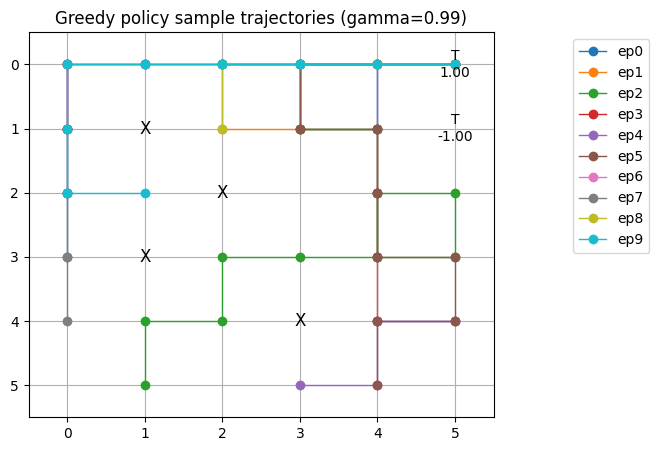

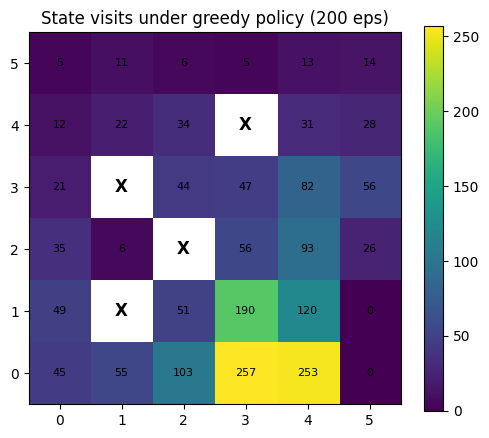

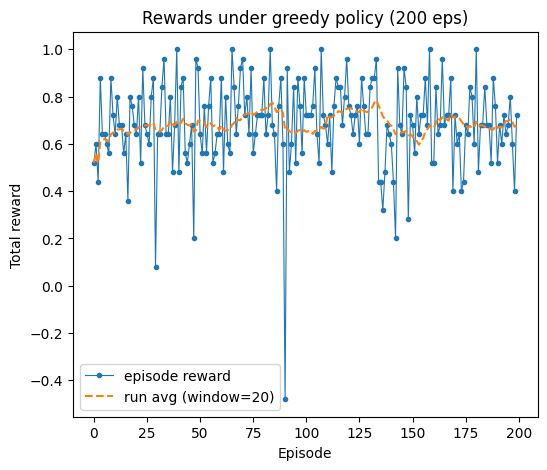

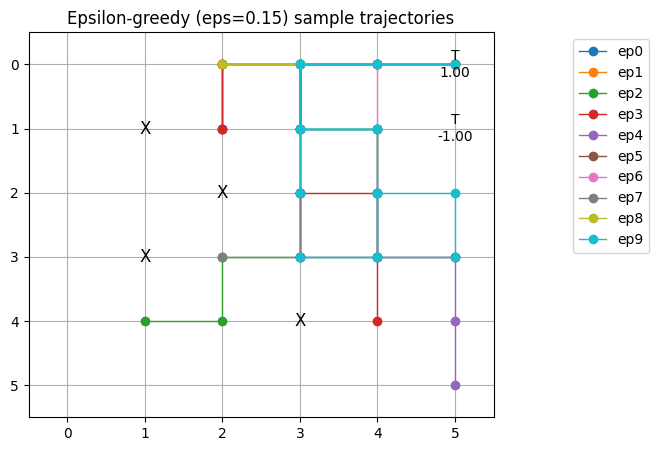

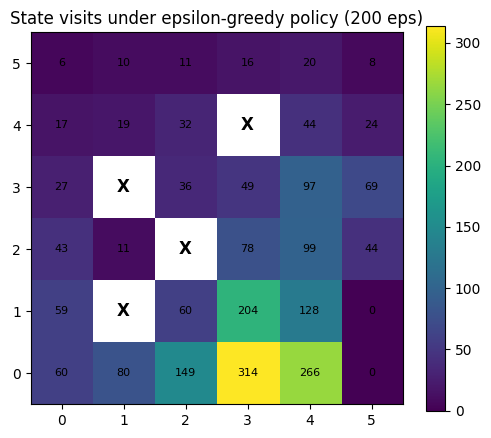

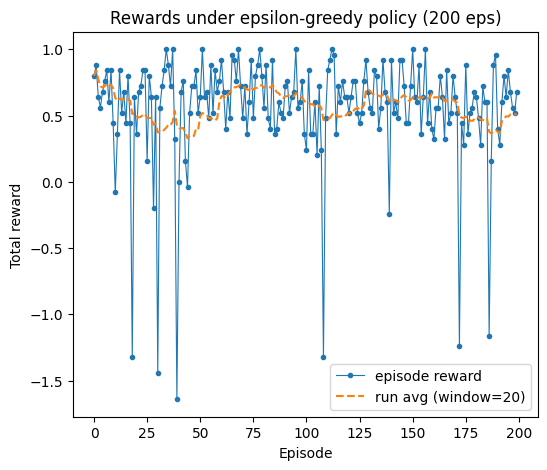

        policy  mean_reward  median_reward  std_reward  min_reward  max_reward
0       greedy        0.686           0.68    0.183641       -0.48         1.0
1  epsilon0.15        0.564           0.64    0.408274       -1.64         1.0


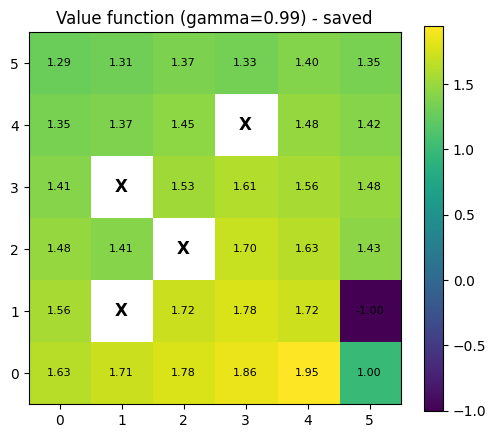

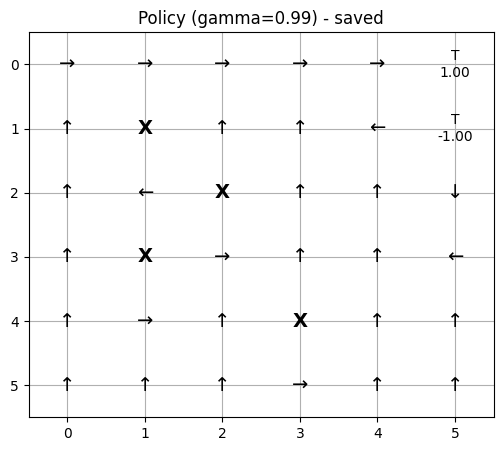

Saved visualizations and CSV to ./mdp_viz_outputs


In [4]:

# Create a challenging gridworld
mdp = GridMDP(
    rows=6,
    cols=6,
    terminals={(0,5): 1.0, (1,5): -1.0},
    obstacles=[(1,1),(2,2),(3,1),(4,3)],
    step_reward=-0.04,
    slip_prob=0.1
)

# Solve with value iteration for two different gammas for comparison
V1, policy1, deltas1, iters1 = value_iteration(mdp, gamma=0.99, theta=1e-5)
V2, policy2, deltas2, iters2 = value_iteration(mdp, gamma=0.9, theta=1e-5)

print(f"Value iteration finished: gamma=0.99 in {iters1} iters, gamma=0.9 in {iters2} iters.")

# Visualizations
plot_convergence(deltas1, title="Convergence (gamma=0.99)")
plot_convergence(deltas2, title="Convergence (gamma=0.90)")

plot_value_heatmap(V1, mdp, title="Value function (gamma=0.99)")
plot_policy(policy1, mdp, title="Policy (gamma=0.99)")

plot_value_heatmap(V2, mdp, title="Value function (gamma=0.90)")
plot_policy(policy2, mdp, title="Policy (gamma=0.90)")

# Simulate greedy policy and epsilon-greedy policy to compare
trajectories_greedy, rewards_greedy, visits_greedy = simulate_policy(mdp, policy1, episodes=200, max_steps=50, epsilon=0.0)
trajectories_eps, rewards_eps, visits_eps = simulate_policy(mdp, policy1, episodes=200, max_steps=50, epsilon=0.15)

# Show sample trajectories and visit heatmaps
plot_trajectories(trajectories_greedy, mdp, n_show=10, title="Greedy policy sample trajectories (gamma=0.99)")
plot_visit_heatmap(visits_greedy, mdp, title="State visits under greedy policy (200 eps)")
plot_rewards_stats(rewards_greedy, title="Rewards under greedy policy (200 eps)")

plot_trajectories(trajectories_eps, mdp, n_show=10, title="Epsilon-greedy (eps=0.15) sample trajectories")
plot_visit_heatmap(visits_eps, mdp, title="State visits under epsilon-greedy policy (200 eps)")
plot_rewards_stats(rewards_eps, title="Rewards under epsilon-greedy policy (200 eps)")

# Compare statistics in a DataFrame
df_stats = pd.DataFrame({
    "policy": ["greedy","epsilon0.15"],
    "mean_reward": [np.mean(rewards_greedy), np.mean(rewards_eps)],
    "median_reward": [np.median(rewards_greedy), np.median(rewards_eps)],
    "std_reward": [np.std(rewards_greedy), np.std(rewards_eps)],
    "min_reward": [np.min(rewards_greedy), np.min(rewards_eps)],
    "max_reward": [np.max(rewards_greedy), np.max(rewards_eps)]
})

if display_dataframe_to_user is not None:
    display_dataframe_to_user("Policy reward comparison", df_stats)
else:
    print(df_stats)

# Save key plots and CSVs into the notebook's working directory for easy download
out_dir = "./mdp_viz_outputs"
os.makedirs(out_dir, exist_ok=True)
plot_value_heatmap(V1, mdp, title="Value function (gamma=0.99) - saved")
plt.savefig(os.path.join(out_dir, "value_gamma_0_99.png"))
plt.close()
plot_policy(policy1, mdp, title="Policy (gamma=0.99) - saved")
plt.savefig(os.path.join(out_dir, "policy_gamma_0_99.png"))
plt.close()

vc_df = pd.DataFrame([(s[0], s[1], visits_greedy.get(s,0)) for s in sorted(visits_greedy.keys())], columns=["row","col","visits"])
vc_df.to_csv(os.path.join(out_dir, "visit_counts_greedy.csv"), index=False)

print(f"Saved visualizations and CSV to {out_dir}")
